## 市场相关性分析

In [1]:
import pymongo
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
startTime = datetime(2022,6,1)
endTime = datetime(2023,1,19, 10)

C:\Users\channelchan\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\channelchan\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', 

In [2]:
# https://www.investing.com/indices/nasdaq-composite-historical-data

In [3]:
symbolList = ['btc_usdt.spot:binance', 'eth_usdt.spot:binance', 'bnb_usdt.spot:binance', 'ltc_usdt.spot:binance','bch_usdt.spot:binance',
             'doge_usdt.spot:binance', 'matic_usdt.spot:binance', 'sol_usdt.spot:binance','link_usdt.spot:binance','uni_usdt.spot:binance',
             'gala_usdt.spot:binance', 'sand_usdt.spot:binance', 'axs_usdt.spot:binance']

client = pymongo.MongoClient('172.16.20.81', 27017)

In [4]:
def readDb(collection, start, end):
    return pd.DataFrame(
        list(collection.find({"datetime": {'$gt': start, '$lt': end}}))
    )

In [5]:

dbClient = client['Kline_1Min_Auto_Db_Plus']
columnsName = ['open', 'high', 'low', 'close', 'volume','datetime']

In [6]:
crytoDict = {
                'btc':readDb(dbClient[symbolList[0]], start=startTime , end=endTime)[columnsName],
                'eth':readDb(dbClient[symbolList[1]], start=startTime , end=endTime)[columnsName],
                'bnb':readDb(dbClient[symbolList[2]], start=startTime , end=endTime)[columnsName],
                'ltc':readDb(dbClient[symbolList[3]], start=startTime , end=endTime)[columnsName],
                'bch':readDb(dbClient[symbolList[4]], start=startTime , end=endTime)[columnsName],
                'doge':readDb(dbClient[symbolList[5]], start=startTime , end=endTime)[columnsName],
                'matic':readDb(dbClient[symbolList[6]], start=startTime , end=endTime)[columnsName],
                'sol':readDb(dbClient[symbolList[7]], start=startTime , end=endTime)[columnsName],
                'link':readDb(dbClient[symbolList[8]], start=startTime , end=endTime)[columnsName],
                'uni':readDb(dbClient[symbolList[9]], start=startTime , end=endTime)[columnsName],
                'gala':readDb(dbClient[symbolList[10]], start=startTime , end=endTime)[columnsName],
                'sand':readDb(dbClient[symbolList[11]], start=startTime , end=endTime)[columnsName],
                'axs':readDb(dbClient[symbolList[12]], start=startTime , end=endTime)[columnsName]
            }

In [7]:
# crytoDict

In [8]:
def resampleDf(data, freq='H'):
#     df = data.drop('_id', axis=1)
    dataDf = data.set_index('datetime')
    dataHourDf = dataDf.resample(freq).agg({'open':'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume':'sum'})
    dataResetDf = dataHourDf.reset_index()
    return dataResetDf

In [9]:
def addSymbol(dataDf, symbolName):
    dataDf['symbol'] = symbolName
    return dataDf

In [10]:
def setIndex(dataDf):
    dataIndex = dataDf.set_index(['datetime', 'symbol'])
    return dataIndex

In [11]:
multiCryptoDict = {}
for key, df in crytoDict.items():
    hourDf = resampleDf(df)
    hourSymbolDf = addSymbol(hourDf, key)
    hourIndexDf = setIndex(hourSymbolDf)
    multiCryptoDict[key] = hourIndexDf

In [12]:
multiDf = pd.concat(list(multiCryptoDict.values())).sort_index()

In [13]:
multiDf

open         high          low  \
datetime            symbol                                          
2022-06-01 00:00:00 axs        24.60000     24.80000     23.95000   
                    bch       198.00000    199.30000    195.60000   
                    bnb       321.90000    324.00000    319.70000   
                    btc     32084.53000  32399.00000  31839.67000   
                    doge        0.08562      0.08623      0.08483   
...                                 ...          ...          ...   
2023-01-19 09:00:00 ltc        83.06000     83.26000     82.75000   
                    matic       0.93900      0.94720      0.93680   
                    sand        0.68620      0.69190      0.67530   
                    sol        20.97000     21.28000     20.91000   
                    uni         6.05400      6.12300      6.05400   

                                  close        volume  
datetime            symbol                             
2022-06-01 00:00:00 axs        24.11000  1.480696e+05  
                    bch       197.00000  5.910073e+03  
                    bnb       322.80000  4.378702e+04  
                    btc     32158.03000  5.899671e+03  
                    doge        0.08574  8.556392e+07  
...                                 ...           ...  
2023-01-19 09:00:00 ltc        82.87000  1.911947e+04  
                    matic       0.93900  3.692852e+06  
                    sand        0.67700  1.512182e+06  
                    sol        21.02000  2.896572e+05  
                    uni         6.06300  5.738776e+04  

[72514 rows x 5 columns]

In [14]:
closePrice = multiDf['close'].unstack()

In [15]:
logPriceDf = np.log(closePrice)

In [16]:
logPriceDf

symbol,axs,bch,bnb,btc,doge,eth,gala,link,ltc,matic,sand,sol,uni
datetime,,,,,,,,,,,,,
2022-06-01 00:00:00,3.182627,5.283204,5.777033,10.378417,-2.456436,7.587387,-2.486027,2.014903,4.229749,-0.403467,0.359072,3.834061,1.750937
2022-06-01 01:00:00,3.179303,5.284725,5.778271,10.377299,-2.454688,7.584468,-2.486027,2.010895,4.231204,-0.400478,0.363879,3.832763,1.750937
2022-06-01 02:00:00,3.134189,5.278625,5.767070,10.363533,-2.456203,7.567625,-2.512689,1.998774,4.212128,-0.420071,0.353680,3.816833,1.728109
2022-06-01 03:00:00,3.126761,5.285739,5.764564,10.361726,-2.453059,7.567454,-2.504334,1.998774,4.218036,-0.420071,0.355434,3.818371,1.726332
2022-06-01 04:00:00,3.140698,5.303802,5.769258,10.367651,-2.447380,7.577460,-2.491931,2.018895,4.226834,-0.410980,0.364018,3.825157,1.738710
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-19 05:00:00,2.093098,4.792479,5.669191,9.941764,-2.513677,7.332016,-3.088067,1.857079,4.425685,-0.050767,-0.341927,3.060115,1.809272
2023-01-19 06:00:00,2.096790,4.792479,5.670915,9.943349,-2.510840,7.333925,-3.088945,1.859418,4.426522,-0.047511,-0.337713,3.051640,1.807633
2023-01-19 07:00:00,2.083185,4.776599,5.658436,9.936800,-2.525729,7.320812,-3.110021,1.845932,4.414252,-0.064005,-0.377023,3.034472,1.799728


In [17]:
import seaborn as sns

def corr_chart(logPriceDf):
    corrDf = logPriceDf.corr()
    mask = np.zeros_like(corrDf)
    mask[np.triu_indices_from(mask)] = True
    for i in range(len(mask)):
        mask[i,i] = 0
    plt.figure(figsize=(15,15))
    with sns.axes_style("white"):
        ax = sns.heatmap(corrDf, mask=mask,square=True,annot=True,cmap="YlGnBu")
    btc_avg_corr = ((corrDf.sum()-1)/13)['btc']
    btc_avg_corr = round(btc_avg_corr,2)
    plt.text(-1,-1,f'The [{logPriceDf.index[0]}] to [{logPriceDf.index[-1]}]\'s Return Array Average Correlation')
    plt.text(-1,-0.6,f'between BTC and others is : {btc_avg_corr}')
    plt.savefig('corr')
    plt.show()

In [18]:
periodParam = 168

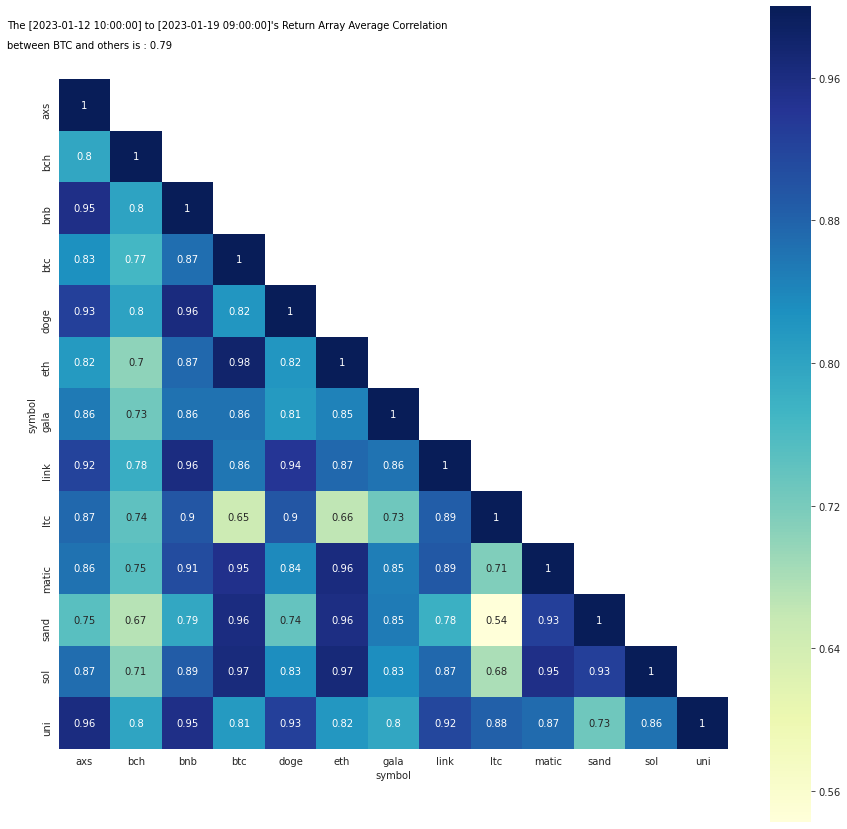

In [19]:
corr_chart(logPriceDf.iloc[-periodParam:])

In [20]:
def absorption_ratio(logReturn):
    '''
    Calculate absorption ratio via PCA.
    Arguments:
    explained_variance -- 1D np.array of explained variance by each pricincipal component, in descending order
    
    n_components -- an integer, a number of principal components to compute absorption ratio
    
    Return:
    ar -- absorption ratio
    '''
    num = len(logReturn[0])
    pca = PCA(n_components=num)
    pca.fit(logReturn)
    explained_variance1 = pca.explained_variance_ratio_[0]
    explained_variance_sum = np.sum(pca.explained_variance_ratio_)
    ar = explained_variance1/ explained_variance_sum
    return ar

In [21]:
closePrice = multiDf.close.unstack()

In [22]:
ar_param = 168
nor_param = ar_param*8
pcaDict = {}
for i in range(len(logPriceDf)-ar_param):
    pcaDict[logPriceDf.iloc[i+ar_param].name] = absorption_ratio(np.array(logPriceDf.iloc[i:i+ar_param]))

In [23]:
arData = pd.Series(pcaDict).to_frame(name='ar')

In [24]:
arData['arNor'] = (arData['ar'].rolling(ar_param).mean()-arData['ar'].rolling(nor_param).mean())/arData['ar'].rolling(nor_param).std()

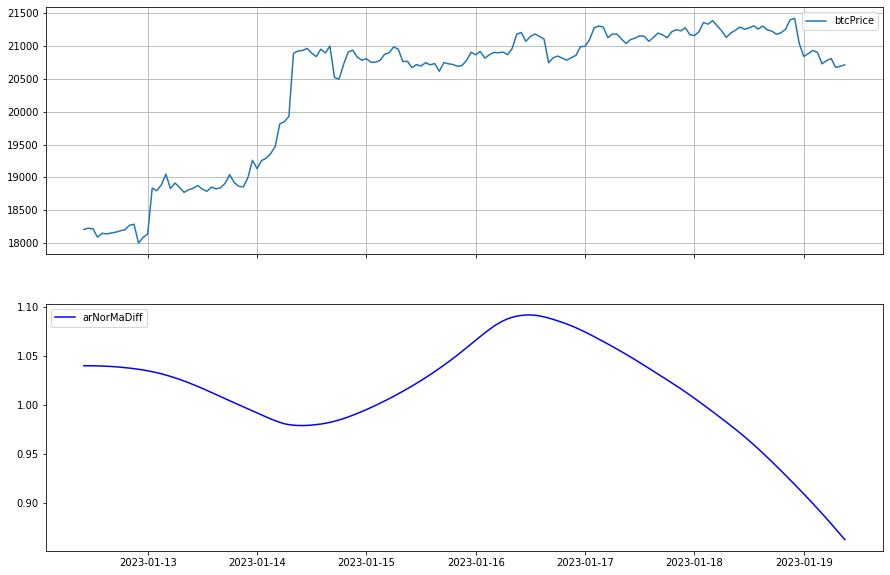

In [25]:
last7Day = 7*24
figBtc, (axBtc, ax1Btc) = plt.subplots(2,1,sharex=True, figsize=(15,10))
axBtc.grid(True)
axBtc.plot(closePrice['btc'].iloc[-last7Day:], label='btcPrice')
axBtc.legend()
ax1Btc.plot(arData['arNor'].iloc[-last7Day:]-arData['arNor'].rolling(nor_param).mean().iloc[-last7Day:], color='b', label='arNorMaDiff')
ax1Btc.legend(loc='upper left')
figBtc.savefig('arNorMaDiff')

In [26]:
def cal_pctChange(data, lastDay, periodList=[7]):
    pctChangeDict = {}
    for period in periodList:
        pctChangeDict[str(period)+'Day'] = round((data.loc[lastDay]/data.loc[lastDay-timedelta(hours=period*24)]-1)*100, 2)
    pctChangeDf = pd.Series(pctChangeDict)
    return pctChangeDf

In [27]:
endTime = arData['arNor'].index[-1]
arNorChangeDf = pd.DataFrame({
    'arNorPctChange': cal_pctChange(arData['arNor'], endTime, [1, 3, 5, 8, 13]),
})

In [28]:
arNorChangeDfT = arNorChangeDf.T

In [29]:
arNorChangeDfT['avg'] = arNorChangeDfT.mean(axis=1)

In [30]:
arNorChangeDfT.to_excel('arNorChangeDfT.xlsx')

In [31]:
# arNorChangeDfT